In [1]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [48]:
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")
houses_wEV = utils.get_pickle(pickle_path / "houses_wEV.pkl")
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")

# Determine outliers
outliers = utils.classify_outliers(train)

train = train.drop(outliers.index)
labels = labels.drop(outliers.index)


Number of Outliers: 37
Percent Removed: 2.33%



In [203]:
# Difference from preceding interval
feat_diff = train.diff(axis=1)

In [270]:
# Identify various possible features/descriptors
features_a = pd.DataFrame(index=train.index)

# Dislike this measurement b/c it's highly time-frame dependent
# features_a['tot_pwr'] = train.sum(axis=1)

features_a['avg_pwr'] = train.mean(axis=1)
features_a['avg_pwr^2'] = features_a['avg_pwr']**2
features_a['avg_pwr^3'] = features_a['avg_pwr']**3

features_a['median_pwr'] = train.median(axis=1)
features_a['median_pwr^2'] = features_a['median_pwr']**2
features_a['median_pwr^3'] = features_a['median_pwr']**3

features_a['min_pwr'] = train.min(axis=1)
features_a['min_pwr^2'] = train.min(axis=1)**2
features_a['min_pwr^3'] = train.min(axis=1)**3

features_a['max_pwr'] = train.max(axis=1)
features_a['max_pwr^2'] = features_a['max_pwr']**2
features_a['max_pwr^3'] = features_a['max_pwr']**3

features_a['diff_max'] = feat_diff.max(axis=1)
features_a['diff_max^2'] = features_a['diff_max']**2
features_a['diff_max^3'] = features_a['diff_max']**3

features_a['<3_avg'] = train[train < 3].mean(axis=1)   
features_a['>3_avg'] = train[train > 3].mean(axis=1)  
features_a['pct_pwr<2'] = train[train < 2].count(axis=1)/train.shape[1]   
features_a['pct_pwr<3'] = train[train < 3].count(axis=1)/train.shape[1]   


# Corresponding labels
features_a['tot_chrgs'] = labels.sum(axis=1)
features_a['label'] = np.where(features_a['tot_chrgs'] > 0, True, False)


features_a.dropna(axis=1, inplace=True)
features_a.to_pickle(pickle_path / "features_a.pkl")

In [271]:
X = features_a.drop(['label', 'tot_chrgs'], axis=1)
y = features_a[['label']]

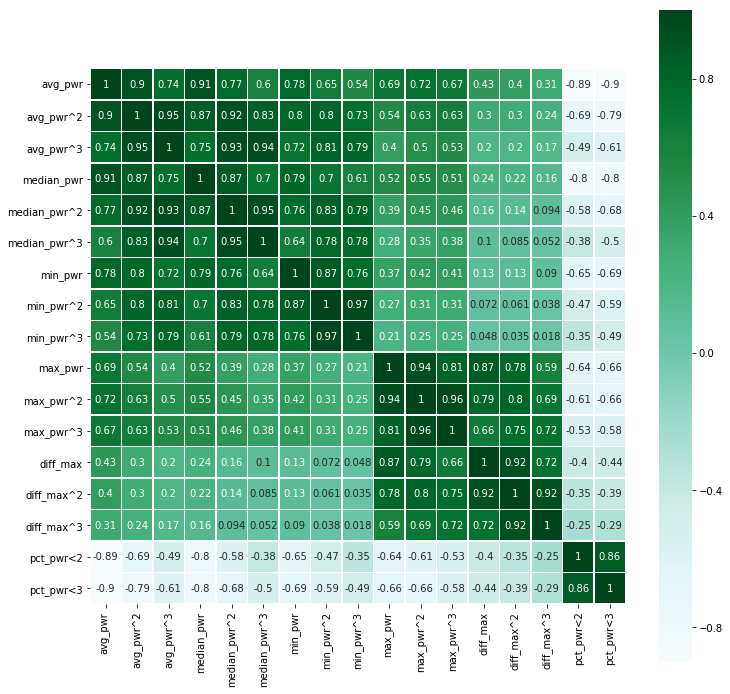

In [285]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(X.corr(), annot=True, square=True, cmap="BuGn", linewidths=.5, ax=ax)
plt.title = "Model A\nHeatmap of Correlation Coefficients"
plt.savefig(fig_path / 'feature_heatmap_a.png',
            dpi=400,  bbox_inches='tight')


In [275]:
# Try different sets of features
# ['tot_pwr', 'avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'tot_chrgs','label']
X1 = X[['avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr']]
X2 = X[['avg_pwr', 'median_pwr', 'min_pwr', 'max_pwr', 'pct_pwr<3', 'diff_max^3']]
X3 = X[['avg_pwr', 'median_pwr', 'max_pwr', 'pct_pwr<3', 'diff_max^3']]
X4 = X[['avg_pwr', 'median_pwr^3', 'max_pwr', 'pct_pwr<3', 'diff_max^3']]
X5 = X[['avg_pwr^3', 'median_pwr^3', 'max_pwr', 'pct_pwr<3', 'diff_max^3']]
X6 = X[['avg_pwr', 'avg_pwr^3', 'median_pwr^3', 'max_pwr', 'pct_pwr<3', 'diff_max^3']]

cases = [X, X1, X2, X3, X4, X5, X6]

In [276]:
# Test feature sets
scores = pd.DataFrame()
for i, X_case in enumerate(cases):
    
    X_train, X_test, y_train, y_test = utils.scale_split_data(X_case,y)

    # Train logistic regression model
    logreg = LogisticRegression(solver='liblinear', random_state=0)
    logreg.fit(X_train, np.ravel(y_train))
    scores = scores.append({'score': logreg.score(X_test, y_test), 
                           'cols': X_case.columns.tolist()}, 
                           ignore_index=True)
    
scores.sort_values('score', ascending=False)

,cols,score
0,"[avg_pwr, avg_pwr^2, avg_pwr^3, median_pwr, me...",0.843188
6,"[avg_pwr, avg_pwr^3, median_pwr^3, max_pwr, pc...",0.840617
5,"[avg_pwr^3, median_pwr^3, max_pwr, pct_pwr<3, ...",0.838046
4,"[avg_pwr, median_pwr^3, max_pwr, pct_pwr<3, di...",0.832905
1,"[avg_pwr, median_pwr, min_pwr, max_pwr]",0.827763
3,"[avg_pwr, median_pwr, max_pwr, pct_pwr<3, diff...",0.827763
2,"[avg_pwr, median_pwr, min_pwr, max_pwr, pct_pw...",0.825193
